This notebook was inspired by this blog post: https://dashee87.github.io/football/python/predicting-football-results-with-statistical-modelling/
The Poisson model essentially follows the initial part of above blog. The rest of the notebook applies the results to estimating Fantasy Premier League Assistant Manager chip expected points for each manager. 

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import json
import requests
from tqdm import tqdm
from datetime import datetime
import dataframe_image as dfi

from scipy.stats import poisson
import statsmodels.api as sm
import statsmodels.formula.api as smf
from random import choices

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

# Fetch data

In [2]:
matches24_25 = pd.read_html('https://fbref.com/en/comps/9/schedule/Premier-League-Scores-and-Fixtures')[0]
matches23_24 = pd.read_html('https://fbref.com/en/comps/9/2023-2024/schedule/2023-2024-Premier-League-Scores-and-Fixtures')[0]
fixtures_fbref = pd.concat([matches23_24, matches24_25], ignore_index=True)
#fixtures_fbref = matches24_25.copy()
fixtures_fbref['Date'] = pd.to_datetime(fixtures_fbref['Date'])
display(fixtures_fbref)

,Wk,Day,Date,Time,Home,xG,Score,xG.1,Away,Attendance,Venue,Referee,Match Report,Notes
0,1.0,Fri,2023-08-11,20:00,Burnley,0.3,0–3,1.9,Manchester City,21572.0,Turf Moor,Craig Pawson,Match Report,NaN
1,1.0,Sat,2023-08-12,12:30,Arsenal,0.8,2–1,1.2,Nott'ham Forest,59984.0,Emirates Stadium,Michael Oliver,Match Report,NaN
2,1.0,Sat,2023-08-12,15:00,Everton,2.7,0–1,1.5,Fulham,39940.0,Goodison Park,Stuart Attwell,Match Report,NaN
3,1.0,Sat,2023-08-12,15:00,Brighton,4.0,4–1,1.5,Luton Town,31872.0,The American Express Community Stadium,David Coote,Match Report,NaN
4,1.0,Sat,2023-08-12,15:00,Sheffield Utd,0.5,0–1,1.9,Crystal Palace,31194.0,Bramall Lane,John Brooks,Match Report,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
838,38.0,Sun,2025-05-25,16:00,Nott'ham Forest,NaN,NaN,NaN,Chelsea,NaN,The City Ground,NaN,Head-to-Head,NaN
839,38.0,Sun,2025-05-25,16:00,Fulham,NaN,NaN,NaN,Manchester City,NaN,Craven Cottage,NaN,Head-to-Head,NaN
840,38.0,Sun,2025-05-25,16:00,Newcastle Utd,NaN,NaN,NaN,Everton,NaN,St James' Park,NaN,Head-to-Head,NaN
841,38.0,Sun,2025-05-25,16:00,Bournemouth,NaN,NaN,NaN,Leicester City,NaN,Vitality Stadium,NaN,Head-to-Head,NaN


In [3]:
results = fixtures_fbref[fixtures_fbref['Score'].notnull()]
results = results.reset_index()
results

,index,Wk,Day,Date,Time,Home,xG,Score,xG.1,Away,Attendance,Venue,Referee,Match Report,Notes
0,0,1.0,Fri,2023-08-11,20:00,Burnley,0.3,0–3,1.9,Manchester City,21572.0,Turf Moor,Craig Pawson,Match Report,NaN
1,1,1.0,Sat,2023-08-12,12:30,Arsenal,0.8,2–1,1.2,Nott'ham Forest,59984.0,Emirates Stadium,Michael Oliver,Match Report,NaN
2,2,1.0,Sat,2023-08-12,15:00,Everton,2.7,0–1,1.5,Fulham,39940.0,Goodison Park,Stuart Attwell,Match Report,NaN
3,3,1.0,Sat,2023-08-12,15:00,Brighton,4.0,4–1,1.5,Luton Town,31872.0,The American Express Community Stadium,David Coote,Match Report,NaN
4,4,1.0,Sat,2023-08-12,15:00,Sheffield Utd,0.5,0–1,1.9,Crystal Palace,31194.0,Bramall Lane,John Brooks,Match Report,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
674,748,30.0,Wed,2025-04-02,19:45,Southampton,0.7,1–1,0.7,Crystal Palace,30158.0,St Mary's Stadium,Andy Madley,Match Report,NaN
675,749,30.0,Wed,2025-04-02,19:45,Bournemouth,1.8,1–2,1.2,Ipswich Town,11192.0,Vitality Stadium,Robert Jones,Match Report,NaN
676,750,30.0,Wed,2025-04-02,19:45,Brighton,0.9,0–3,1.2,Aston Villa,27895.0,The American Express Stadium,Stuart Attwell,Match Report,NaN
677,751,30.0,Wed,2025-04-02,20:00,Liverpool,1.5,1–0,0.9,Everton,60457.0,Anfield,Samuel Barrott,Match Report,NaN


# Process data

In [4]:
results['home_goals'] = results['Score'].apply(lambda x: x.split('–')[0])
results['away_goals'] = results['Score'].apply(lambda x: x.split('–')[1])
results

,index,Wk,Day,Date,Time,Home,xG,Score,xG.1,Away,Attendance,Venue,Referee,Match Report,Notes,home_goals,away_goals
0,0,1.0,Fri,2023-08-11,20:00,Burnley,0.3,0–3,1.9,Manchester City,21572.0,Turf Moor,Craig Pawson,Match Report,NaN,0,3
1,1,1.0,Sat,2023-08-12,12:30,Arsenal,0.8,2–1,1.2,Nott'ham Forest,59984.0,Emirates Stadium,Michael Oliver,Match Report,NaN,2,1
2,2,1.0,Sat,2023-08-12,15:00,Everton,2.7,0–1,1.5,Fulham,39940.0,Goodison Park,Stuart Attwell,Match Report,NaN,0,1
3,3,1.0,Sat,2023-08-12,15:00,Brighton,4.0,4–1,1.5,Luton Town,31872.0,The American Express Community Stadium,David Coote,Match Report,NaN,4,1
4,4,1.0,Sat,2023-08-12,15:00,Sheffield Utd,0.5,0–1,1.9,Crystal Palace,31194.0,Bramall Lane,John Brooks,Match Report,NaN,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
674,748,30.0,Wed,2025-04-02,19:45,Southampton,0.7,1–1,0.7,Crystal Palace,30158.0,St Mary's Stadium,Andy Madley,Match Report,NaN,1,1
675,749,30.0,Wed,2025-04-02,19:45,Bournemouth,1.8,1–2,1.2,Ipswich Town,11192.0,Vitality Stadium,Robert Jones,Match Report,NaN,1,2
676,750,30.0,Wed,2025-04-02,19:45,Brighton,0.9,0–3,1.2,Aston Villa,27895.0,The American Express Stadium,Stuart Attwell,Match Report,NaN,0,3
677,751,30.0,Wed,2025-04-02,20:00,Liverpool,1.5,1–0,0.9,Everton,60457.0,Anfield,Samuel Barrott,Match Report,NaN,1,0


In [5]:
current_date = dt.datetime.today()
results['days_since'] = results['Date'].apply(lambda x: (current_date-x).days)
results

,index,Wk,Day,Date,Time,Home,xG,Score,xG.1,Away,Attendance,Venue,Referee,Match Report,Notes,home_goals,away_goals,days_since
0,0,1.0,Fri,2023-08-11,20:00,Burnley,0.3,0–3,1.9,Manchester City,21572.0,Turf Moor,Craig Pawson,Match Report,NaN,0,3,602
1,1,1.0,Sat,2023-08-12,12:30,Arsenal,0.8,2–1,1.2,Nott'ham Forest,59984.0,Emirates Stadium,Michael Oliver,Match Report,NaN,2,1,601
2,2,1.0,Sat,2023-08-12,15:00,Everton,2.7,0–1,1.5,Fulham,39940.0,Goodison Park,Stuart Attwell,Match Report,NaN,0,1,601
3,3,1.0,Sat,2023-08-12,15:00,Brighton,4.0,4–1,1.5,Luton Town,31872.0,The American Express Community Stadium,David Coote,Match Report,NaN,4,1,601
4,4,1.0,Sat,2023-08-12,15:00,Sheffield Utd,0.5,0–1,1.9,Crystal Palace,31194.0,Bramall Lane,John Brooks,Match Report,NaN,0,1,601
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
674,748,30.0,Wed,2025-04-02,19:45,Southampton,0.7,1–1,0.7,Crystal Palace,30158.0,St Mary's Stadium,Andy Madley,Match Report,NaN,1,1,2
675,749,30.0,Wed,2025-04-02,19:45,Bournemouth,1.8,1–2,1.2,Ipswich Town,11192.0,Vitality Stadium,Robert Jones,Match Report,NaN,1,2,2
676,750,30.0,Wed,2025-04-02,19:45,Brighton,0.9,0–3,1.2,Aston Villa,27895.0,The American Express Stadium,Stuart Attwell,Match Report,NaN,0,3,2
677,751,30.0,Wed,2025-04-02,20:00,Liverpool,1.5,1–0,0.9,Everton,60457.0,Anfield,Samuel Barrott,Match Report,NaN,1,0,2


In [6]:
results = results[results.days_since <= 365]
results

,index,Wk,Day,Date,Time,Home,xG,Score,xG.1,Away,Attendance,Venue,Referee,Match Report,Notes,home_goals,away_goals,days_since
301,334,31.0,Thu,2024-04-04,19:30,Liverpool,1.8,3–1,0.6,Sheffield Utd,60055.0,Anfield,Stuart Attwell,Match Report,NaN,3,1,365
302,335,31.0,Thu,2024-04-04,20:15,Chelsea,3.0,4–3,1.5,Manchester Utd,39694.0,Stamford Bridge,Jarred Gillett,Match Report,NaN,4,3,365
303,337,32.0,Sat,2024-04-06,12:30,Crystal Palace,1.1,2–4,1.9,Manchester City,25132.0,Selhurst Park,Paul Tierney,Match Report,NaN,2,4,363
304,338,32.0,Sat,2024-04-06,15:00,Luton Town,1.5,2–1,0.4,Bournemouth,11797.0,Kenilworth Road Stadium,Andy Madley,Match Report,NaN,2,1,363
305,339,32.0,Sat,2024-04-06,15:00,Everton,0.9,1–0,0.5,Burnley,39125.0,Goodison Park,Michael Oliver,Match Report,NaN,1,0,363
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
674,748,30.0,Wed,2025-04-02,19:45,Southampton,0.7,1–1,0.7,Crystal Palace,30158.0,St Mary's Stadium,Andy Madley,Match Report,NaN,1,1,2
675,749,30.0,Wed,2025-04-02,19:45,Bournemouth,1.8,1–2,1.2,Ipswich Town,11192.0,Vitality Stadium,Robert Jones,Match Report,NaN,1,2,2
676,750,30.0,Wed,2025-04-02,19:45,Brighton,0.9,0–3,1.2,Aston Villa,27895.0,The American Express Stadium,Stuart Attwell,Match Report,NaN,0,3,2
677,751,30.0,Wed,2025-04-02,20:00,Liverpool,1.5,1–0,0.9,Everton,60457.0,Anfield,Samuel Barrott,Match Report,NaN,1,0,2


# Model

In [7]:
def predict_average_goals(foot_model, homeTeam, awayTeam):
    home_goals_avg = foot_model.predict(pd.DataFrame(data={'team': homeTeam, 
                                                            'opponent': awayTeam,'home':1},
                                                      index=[1])).values[0]
    away_goals_avg = foot_model.predict(pd.DataFrame(data={'team': awayTeam, 
                                                            'opponent': homeTeam,'home':0},
                                                      index=[1])).values[0]
    return home_goals_avg, away_goals_avg

In [8]:
goal_model_data = pd.concat([results[['Home','Away','home_goals']].assign(home=1).rename(
            columns={'Home':'team', 'Away':'opponent','home_goals':'goals'}),
           results[['Away','Home','away_goals']].assign(home=0).rename(
            columns={'Away':'team', 'Home':'opponent','away_goals':'goals'})]).reset_index(drop=True)

goal_model_data['goals'] = goal_model_data['goals'].apply(lambda x: int(x))

goal_model_data

,team,opponent,goals,home
0,Liverpool,Sheffield Utd,3,1
1,Chelsea,Manchester Utd,4,1
2,Crystal Palace,Manchester City,2,1
3,Luton Town,Bournemouth,2,1
4,Everton,Burnley,1,1
...,...,...,...,...
751,Crystal Palace,Southampton,1,0
752,Ipswich Town,Bournemouth,2,0
753,Aston Villa,Brighton,3,0
754,Everton,Liverpool,0,0


In [9]:
poisson_model = smf.glm(formula="goals ~ home + team + opponent", 
                        data=goal_model_data, 
                        family=sm.families.Poisson()).fit()

print(poisson_model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  goals   No. Observations:                  756
Model:                            GLM   Df Residuals:                      710
Model Family:                 Poisson   Df Model:                           45
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1108.4
Date:                Fri, 04 Apr 2025   Deviance:                       761.39
Time:                        15:18:27   Pearson chi2:                     649.
No. Iterations:                     5   Pseudo R-squ. (CS):             0.2010
Covariance Type:            nonrobust                                         
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

In [10]:
median_attack_value = poisson_model.params.iloc[1:23].median()
median_attack_team = (poisson_model.params.iloc[1:23] - median_attack_value).abs().idxmin()
median_defense_value = poisson_model.params.iloc[23:45].median()
median_defense_team = (poisson_model.params.iloc[23:45] - median_defense_value).abs().idxmin()
print(f'Median attack: {median_attack_team}')
print(f'Median defense: {median_defense_team}')

Median attack: team[T.Brighton]
Median defense: opponent[T.Brighton]


In [11]:
teams = "Arsenal,Aston Villa,Bournemouth,Brentford,Brighton,Chelsea,Crystal Palace,Everton,Fulham,Ipswich Town,Leicester City,Liverpool,Manchester City,Manchester Utd,Newcastle Utd,Nott'ham Forest,Southampton,Tottenham,West Ham,Wolves" 
teams = teams.split(',')

In [12]:
ratings = []
for team in teams:
    home_goals_avg, _ = predict_average_goals(poisson_model, team, median_defense_team.split('.')[1][:-1])
    _, away_goals_avg = predict_average_goals(poisson_model, median_defense_team.split('.')[1][:-1], team)
    team_attack_rating = np.mean((home_goals_avg, away_goals_avg))
   

    _, away_goals_avg = predict_average_goals(poisson_model, team, median_attack_team.split('.')[1][:-1])
    home_goals_avg,_  = predict_average_goals(poisson_model, median_attack_team.split('.')[1][:-1], team)
    team_defense_rating = np.mean((home_goals_avg, away_goals_avg))

    team_goal_difference_rating = team_attack_rating - team_defense_rating

    ratings.append((team, team_attack_rating, team_defense_rating, team_goal_difference_rating))

ratings_df = pd.DataFrame(ratings, columns=['team', 'attack_rating', 'defense_rating', 'goal_difference_rating']).sort_values(by='goal_difference_rating', ascending=False).reset_index(drop=True)
ratings_df.index += 1

dfi.export(ratings_df, "ratings.png", table_conversion='matplotlib',)

display(ratings_df)

,team,attack_rating,defense_rating,goal_difference_rating
1,Liverpool,2.283136,1.030811,1.252326
2,Arsenal,1.978376,0.741694,1.236682
3,Manchester City,2.276290,1.109062,1.167227
4,Chelsea,2.094037,1.277353,0.816684
5,Newcastle Utd,1.914273,1.245920,0.668353
6,Crystal Palace,1.632780,1.092139,0.540641
7,Tottenham,1.878353,1.457630,0.420724
8,Nott'ham Forest,1.655022,1.236428,0.418593
9,Bournemouth,1.563902,1.264937,0.298966
10,Brentford,1.764941,1.472223,0.292718


# Predict fixtures

In [13]:
def scoreline_probabilities(foot_model, homeTeam, awayTeam, max_goals=10):
    home_goals_avg, away_goals_avg = predict_average_goals(foot_model, homeTeam, awayTeam)
    team_pred = [[poisson.pmf(i, team_avg) for i in range(0, max_goals+1)] for team_avg in [home_goals_avg, away_goals_avg]]
    return(np.outer(np.array(team_pred[0]), np.array(team_pred[1])))

In [14]:
fixtures = fixtures_fbref[(fixtures_fbref['Score'].isnull()) & (fixtures_fbref['Wk'].notnull())].reset_index()
fixtures

,index,Wk,Day,Date,Time,Home,xG,Score,xG.1,Away,Attendance,Venue,Referee,Match Report,Notes
0,754,31.0,Sat,2025-04-05,12:30,Everton,NaN,NaN,NaN,Arsenal,NaN,Goodison Park,NaN,Head-to-Head,NaN
1,755,31.0,Sat,2025-04-05,15:00,Crystal Palace,NaN,NaN,NaN,Brighton,NaN,Selhurst Park,NaN,Head-to-Head,NaN
2,756,31.0,Sat,2025-04-05,15:00,Ipswich Town,NaN,NaN,NaN,Wolves,NaN,Portman Road Stadium,NaN,Head-to-Head,NaN
3,757,31.0,Sat,2025-04-05,15:00,West Ham,NaN,NaN,NaN,Bournemouth,NaN,London Stadium,NaN,Head-to-Head,NaN
4,758,31.0,Sat,2025-04-05,17:30,Aston Villa,NaN,NaN,NaN,Nott'ham Forest,NaN,Villa Park,NaN,Head-to-Head,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76,838,38.0,Sun,2025-05-25,16:00,Nott'ham Forest,NaN,NaN,NaN,Chelsea,NaN,The City Ground,NaN,Head-to-Head,NaN
77,839,38.0,Sun,2025-05-25,16:00,Fulham,NaN,NaN,NaN,Manchester City,NaN,Craven Cottage,NaN,Head-to-Head,NaN
78,840,38.0,Sun,2025-05-25,16:00,Newcastle Utd,NaN,NaN,NaN,Everton,NaN,St James' Park,NaN,Head-to-Head,NaN
79,841,38.0,Sun,2025-05-25,16:00,Bournemouth,NaN,NaN,NaN,Leicester City,NaN,Vitality Stadium,NaN,Head-to-Head,NaN


In [15]:
home_team = 'Chelsea'
away_team = 'Tottenham'
outcome_matrix = scoreline_probabilities(poisson_model, home_team, away_team)

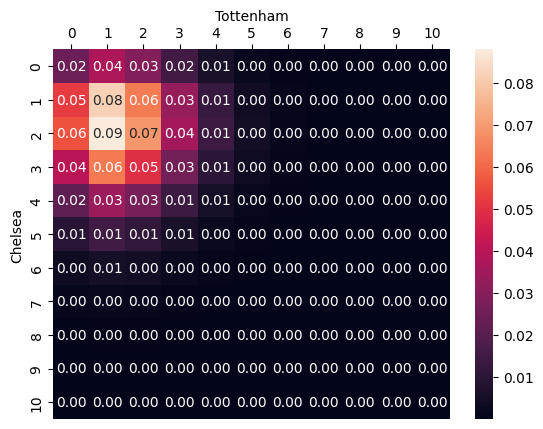

In [16]:
ax = sns.heatmap(outcome_matrix, annot=True, fmt=".2f")
ax.set(xlabel=away_team, ylabel=home_team)
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')

In [17]:
poisson_model.predict(pd.DataFrame(data={'team': 'Everton', 'opponent': 'Liverpool', 'home':1},index=[1]))

1    0.781174
dtype: float64

In [18]:
poisson_model.predict(pd.DataFrame(data={'team': 'Tottenham', 'opponent': 'Chelsea', 'home':0},index=[1]))

1    1.565974
dtype: float64

In [19]:
all_probabilities = []
for _, fixture in fixtures.iterrows():
    # probability of different scorelines
    outcome_matrix = scoreline_probabilities(poisson_model, fixture['Home'], fixture['Away'])
    # match outcome probabilities
    probability_home_win = outcome_matrix[np.tril_indices_from(outcome_matrix, k=-1)].sum()
    probability_draw = np.trace(outcome_matrix)
    probability_away_win = outcome_matrix[np.triu_indices_from(outcome_matrix, k=1)].sum()
    # add probabilities to list
    all_probabilities.append([probability_home_win, probability_draw, probability_away_win])

# add all probabilites to fixtures df
fixtures[['home_win_probability', 'draw_probability', 'away_win_probability']] = all_probabilities

display(fixtures)

,index,Wk,Day,Date,Time,Home,xG,Score,xG.1,Away,Attendance,Venue,Referee,Match Report,Notes,home_win_probability,draw_probability,away_win_probability
0,754,31.0,Sat,2025-04-05,12:30,Everton,NaN,NaN,NaN,Arsenal,NaN,Goodison Park,NaN,Head-to-Head,NaN,0.144863,0.269257,0.585879
1,755,31.0,Sat,2025-04-05,15:00,Crystal Palace,NaN,NaN,NaN,Brighton,NaN,Selhurst Park,NaN,Head-to-Head,NaN,0.526115,0.240378,0.233505
2,756,31.0,Sat,2025-04-05,15:00,Ipswich Town,NaN,NaN,NaN,Wolves,NaN,Portman Road Stadium,NaN,Head-to-Head,NaN,0.312141,0.236935,0.450922
3,757,31.0,Sat,2025-04-05,15:00,West Ham,NaN,NaN,NaN,Bournemouth,NaN,London Stadium,NaN,Head-to-Head,NaN,0.244386,0.239918,0.515694
4,758,31.0,Sat,2025-04-05,17:30,Aston Villa,NaN,NaN,NaN,Nott'ham Forest,NaN,Villa Park,NaN,Head-to-Head,NaN,0.344986,0.239942,0.415071
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76,838,38.0,Sun,2025-05-25,16:00,Nott'ham Forest,NaN,NaN,NaN,Chelsea,NaN,The City Ground,NaN,Head-to-Head,NaN,0.341755,0.233711,0.424532
77,839,38.0,Sun,2025-05-25,16:00,Fulham,NaN,NaN,NaN,Manchester City,NaN,Craven Cottage,NaN,Head-to-Head,NaN,0.223151,0.223749,0.553095
78,840,38.0,Sun,2025-05-25,16:00,Newcastle Utd,NaN,NaN,NaN,Everton,NaN,St James' Park,NaN,Head-to-Head,NaN,0.521647,0.260805,0.217548
79,841,38.0,Sun,2025-05-25,16:00,Bournemouth,NaN,NaN,NaN,Leicester City,NaN,Vitality Stadium,NaN,Head-to-Head,NaN,0.709086,0.179245,0.111647


# FPL Assistant Manager Chip

In [20]:
def simulate_match(foot_model, homeTeam, awayTeam):
    '''
    Simulate the outcome of a single match.
    '''
    
    # simulate scoreline
    home_goals_avg_, away_goals_avg_ = predict_average_goals(foot_model, homeTeam, awayTeam)
    home_goals = poisson.rvs(home_goals_avg_)
    away_goals = poisson.rvs(away_goals_avg_)

    if home_goals > away_goals:
        outcome = 'home_win'
    elif home_goals == away_goals:   
        outcome = 'draw'
    else:
        outcome = 'away_win'

    return outcome, home_goals, away_goals
    #return choices(['home_win', 'draw', 'away_win'], probabilities)[0]

In [21]:
def table_bonus_check(focal_team, opponent, league_table):
    focal_team_rank = league_table.loc[league_table.Squad==focal_team, 'Rk'].values[0]
    opponent_rank = league_table.loc[league_table.Squad==opponent, 'Rk'].values[0]
    if focal_team_rank - opponent_rank >= 5:
        return 1.0
    else:
        return 0.0

In [22]:
def calculate_manager_points(outcome, home_goals, away_goals, home_team, away_team, gameweek, league_table, manager_xp):
    # CALCULATE EXPECTED MANAGER POINTS FOR HOME TEAM
    new_row1 = [gameweek, home_team, 0]
    table_bonus_coefficient = table_bonus_check(home_team, away_team, league_table) # 1 or 0
    # points for win
    if outcome=='home_win':
        new_row1[2] = (6 + 10*table_bonus_coefficient)
    # points for draw
    elif outcome=='draw':
        new_row1[2] = (3 + 5*table_bonus_coefficient)
    # goals scored
    new_row1[2] += home_goals
    # points for clean sheet
    if away_goals==0:
        new_row1[2] += 2

    # CALCULATE EXPECTED MANAGER POINTS FOR AWAY TEAM
    new_row2 = [gameweek, away_team, 0]
    table_bonus_coefficient = table_bonus_check(away_team, home_team, league_table) # 1 or 0
    # points for win
    if outcome=='away_win':
        new_row2[2] += (6 + 10*table_bonus_coefficient)
    # points for draw
    elif outcome=='draw':
        new_row2[2] += (3 + 5*table_bonus_coefficient)
    # goals scored
    new_row2[2] += away_goals
    # points for clean sheet
    if home_goals==0:
        new_row2[2] += 2

    # add rows to manager_xp
    manager_xp.extend([new_row1, new_row2])

    return manager_xp

In [23]:
def simulate_season(league_table, fixtures, foot_model, final_gameweek=38):
    '''Simulate a whole season or up to certain gameweek.'''
    first_index = fixtures.event.first_valid_index()
    current_week = fixtures.loc[first_index,'event'].copy()
    league_table_snapshot = league_table.copy()
    fixtures = fixtures[fixtures.event<=final_gameweek].copy()
    manager_xp = []
    for _, fixture in fixtures.iterrows():
        fixture_week = fixture.event
        if np.isnan(fixture_week):
            continue
        elif fixture_week == current_week:
            pass  
        elif fixture_week == (current_week + 1):
            league_table = league_table.sort_values(by=['Pts', 'GD', 'GF'], ascending=False)
            league_table['Rk'] = np.arange(1,21)
            league_table_snapshot = league_table.copy()
            current_week += 1
        else:
            print('Incorrect gameweek!')
            break

        home_team_ = fixture.home_team
        away_team_ = fixture.away_team
        # simulate match outcome
        outcome, home_goals, away_goals = simulate_match(foot_model, home_team_, away_team_)

        # calculate manager points
        manager_xp = calculate_manager_points(outcome, home_goals, away_goals, home_team_, away_team_, current_week, league_table_snapshot, manager_xp)

        # update matches played
        league_table.loc[league_table['Squad']==home_team_, 'MP'] += 1
        league_table.loc[league_table['Squad']==away_team_, 'MP'] += 1
        # update league table 
        league_table.loc[league_table['Squad']==home_team_, 'GF'] += home_goals
        league_table.loc[league_table['Squad']==home_team_, 'GA'] += away_goals
        league_table.loc[league_table['Squad']==home_team_, 'GD'] += home_goals - away_goals
        league_table.loc[league_table['Squad']==away_team_, 'GF'] += away_goals
        league_table.loc[league_table['Squad']==away_team_, 'GA'] += home_goals
        league_table.loc[league_table['Squad']==away_team_, 'GD'] += away_goals - home_goals
        if outcome=='home_win':
            league_table.loc[league_table['Squad']==home_team_, 'Pts'] += 3
            league_table.loc[league_table['Squad']==home_team_, 'W'] += 1
            league_table.loc[league_table['Squad']==away_team_, 'L'] += 1
        elif outcome=='draw':
            league_table.loc[league_table['Squad']==home_team_, 'Pts'] += 1
            league_table.loc[league_table['Squad']==away_team_, 'Pts'] += 1
            league_table.loc[league_table['Squad']==home_team_, 'D'] += 1
            league_table.loc[league_table['Squad']==away_team_, 'D'] += 1
        elif outcome=='away_win':
            league_table.loc[league_table['Squad']==away_team_, 'Pts'] += 3
            league_table.loc[league_table['Squad']==away_team_, 'W'] += 1
            league_table.loc[league_table['Squad']==home_team_, 'L'] += 1
        else: 
            print('No valid result for:')
            print(fixture)
    
    if final_gameweek==38:
        assert np.all(league_table['MP']==38), 'All teams have not played 38 games!'

    league_table = league_table.sort_values(by=['Pts', 'GD', 'GF'], ascending=False)
    league_table['Rk'] = np.arange(1,21)

    return league_table, manager_xp

In [24]:
league_table = pd.read_html('https://fbref.com/en/comps/9/Premier-League-Stats')[0]
league_table

,Rk,Squad,MP,W,D,L,GF,GA,GD,Pts,Pts/MP,xG,xGA,xGD,xGD/90,Last 5,Attendance,Top Team Scorer,Goalkeeper,Notes
0,1,Liverpool,30,22,7,1,70,27,43,73,2.43,66.4,26.0,40.4,1.35,D W W W W,60311,Mohamed Salah - 27,Alisson,NaN
1,2,Arsenal,30,17,10,3,55,25,30,61,2.03,46.7,25.7,21.0,0.70,L D D W W,60276,Kai Havertz - 9,David Raya,NaN
2,3,Nott'ham Forest,30,17,6,7,50,35,15,57,1.90,37.0,35.6,1.4,0.05,L D W W W,30091,Chris Wood - 18,Matz Sels,NaN
3,4,Chelsea,30,15,7,8,54,37,17,52,1.73,57.0,40.3,16.7,0.56,L W W L W,39610,Cole Palmer - 14,Robert Sánchez,NaN
4,5,Manchester City,30,15,6,9,57,40,17,51,1.70,53.6,39.5,14.1,0.47,L W L D W,52819,Erling Haaland - 21,Ederson,NaN
5,6,Newcastle Utd,29,15,5,9,49,39,10,50,1.72,47.5,36.9,10.6,0.37,L W L W W,52177,Alexander Isak - 20,Nick Pope,NaN
6,7,Aston Villa,30,13,9,8,44,45,-1,48,1.60,42.4,40.9,1.5,0.05,D W L W W,41958,Ollie Watkins - 13,Emiliano Martínez,NaN
7,8,Brighton,30,12,11,7,48,45,3,47,1.57,44.5,42.3,2.2,0.07,W W W D L,31888,João Pedro - 8,Bart Verbruggen,NaN
8,9,Fulham,30,12,9,9,44,40,4,45,1.50,40.8,35.2,5.6,0.19,L W L W L,26592,Raúl Jiménez - 10,Bernd Leno,NaN
9,10,Bournemouth,30,12,8,10,49,38,11,44,1.47,54.8,39.9,14.9,0.50,L L D L L,11209,Justin Kluivert - 12,Kepa Arrizabalaga,NaN


In [25]:
fpl_fixtures_data = json.loads(requests.get('https://fantasy.premierleague.com/api/fixtures/').text)
fpl_fixtures = pd.DataFrame(fpl_fixtures_data)
fpl_fixtures['home_team'] = [teams[i] for i in fpl_fixtures['team_h']-1]
fpl_fixtures['away_team'] = [teams[i] for i in fpl_fixtures['team_a']-1]
fpl_fixtures

,code,event,finished,finished_provisional,id,kickoff_time,minutes,provisional_start_time,started,team_a,team_a_score,team_h,team_h_score,stats,team_h_difficulty,team_a_difficulty,pulse_id,home_team,away_team
0,2444470,1,True,True,1,2024-08-16T19:00:00Z,90,False,True,9,0.0,14,1.0,"[{'identifier': 'goals_scored', 'a': [], 'h': ...",3,3,115827,Manchester Utd,Fulham
1,2444473,1,True,True,4,2024-08-17T11:30:00Z,90,False,True,12,2.0,10,0.0,"[{'identifier': 'goals_scored', 'a': [{'value'...",5,2,115830,Ipswich Town,Liverpool
2,2444471,1,True,True,2,2024-08-17T14:00:00Z,90,False,True,20,0.0,1,2.0,"[{'identifier': 'goals_scored', 'a': [], 'h': ...",2,4,115828,Arsenal,Wolves
3,2444472,1,True,True,3,2024-08-17T14:00:00Z,90,False,True,5,3.0,8,0.0,"[{'identifier': 'goals_scored', 'a': [{'value'...",3,3,115829,Everton,Brighton
4,2444474,1,True,True,5,2024-08-17T14:00:00Z,90,False,True,17,0.0,15,1.0,"[{'identifier': 'goals_scored', 'a': [], 'h': ...",2,4,115831,Newcastle Utd,Southampton
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
375,2444845,38,False,False,376,2025-05-25T15:00:00Z,0,False,False,8,NaN,15,NaN,[],2,4,116202,Newcastle Utd,Everton
376,2444846,38,False,False,377,2025-05-25T15:00:00Z,0,False,False,6,NaN,16,NaN,[],4,4,116203,Nott'ham Forest,Chelsea
377,2444847,38,False,False,378,2025-05-25T15:00:00Z,0,False,False,1,NaN,17,NaN,[],4,2,116204,Southampton,Arsenal
378,2444848,38,False,False,379,2025-05-25T15:00:00Z,0,False,False,5,NaN,18,NaN,[],3,3,116205,Tottenham,Brighton


In [26]:
fixtures = fpl_fixtures[fpl_fixtures['team_h_score'].isnull()].reset_index(drop=True)
fixtures

,code,event,finished,finished_provisional,id,kickoff_time,minutes,provisional_start_time,started,team_a,team_a_score,team_h,team_h_score,stats,team_h_difficulty,team_a_difficulty,pulse_id,home_team,away_team
0,2444773,31,False,False,304,2025-04-05T11:30:00Z,0,False,False,1,NaN,8,NaN,[],4,3,116130,Everton,Arsenal
1,2444772,31,False,False,303,2025-04-05T14:00:00Z,0,False,False,5,NaN,7,NaN,[],3,3,116129,Crystal Palace,Brighton
2,2444775,31,False,False,306,2025-04-05T14:00:00Z,0,False,False,20,NaN,10,NaN,[],2,2,116132,Ipswich Town,Wolves
3,2444779,31,False,False,310,2025-04-05T14:00:00Z,0,False,False,3,NaN,19,NaN,[],3,2,116136,West Ham,Bournemouth
4,2444770,31,False,False,301,2025-04-05T16:30:00Z,0,False,False,16,NaN,2,NaN,[],3,3,116127,Aston Villa,Nott'ham Forest
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76,2444845,38,False,False,376,2025-05-25T15:00:00Z,0,False,False,8,NaN,15,NaN,[],2,4,116202,Newcastle Utd,Everton
77,2444846,38,False,False,377,2025-05-25T15:00:00Z,0,False,False,6,NaN,16,NaN,[],4,4,116203,Nott'ham Forest,Chelsea
78,2444847,38,False,False,378,2025-05-25T15:00:00Z,0,False,False,1,NaN,17,NaN,[],4,2,116204,Southampton,Arsenal
79,2444848,38,False,False,379,2025-05-25T15:00:00Z,0,False,False,5,NaN,18,NaN,[],3,3,116205,Tottenham,Brighton


In [27]:
all_probabilities = []
for _, fixture in fixtures.iterrows():
    # probability of different scorelines
    outcome_matrix = scoreline_probabilities(poisson_model, fixture['home_team'], fixture['away_team'])
    # match outcome probabilities
    probability_home_win = outcome_matrix[np.tril_indices_from(outcome_matrix, k=-1)].sum()
    probability_draw = np.trace(outcome_matrix)
    probability_away_win = outcome_matrix[np.triu_indices_from(outcome_matrix, k=1)].sum()
    # add probabilities to list
    all_probabilities.append([probability_home_win, probability_draw, probability_away_win])

# add all probabilites to fixtures df
fixtures[['home_win_probability', 'draw_probability', 'away_win_probability']] = all_probabilities

fixtures

,code,event,finished,finished_provisional,id,kickoff_time,minutes,provisional_start_time,started,team_a,...,team_h_score,stats,team_h_difficulty,team_a_difficulty,pulse_id,home_team,away_team,home_win_probability,draw_probability,away_win_probability
0,2444773,31,False,False,304,2025-04-05T11:30:00Z,0,False,False,1,...,NaN,[],4,3,116130,Everton,Arsenal,0.144863,0.269257,0.585879
1,2444772,31,False,False,303,2025-04-05T14:00:00Z,0,False,False,5,...,NaN,[],3,3,116129,Crystal Palace,Brighton,0.526115,0.240378,0.233505
2,2444775,31,False,False,306,2025-04-05T14:00:00Z,0,False,False,20,...,NaN,[],2,2,116132,Ipswich Town,Wolves,0.312141,0.236935,0.450922
3,2444779,31,False,False,310,2025-04-05T14:00:00Z,0,False,False,3,...,NaN,[],3,2,116136,West Ham,Bournemouth,0.244386,0.239918,0.515694
4,2444770,31,False,False,301,2025-04-05T16:30:00Z,0,False,False,16,...,NaN,[],3,3,116127,Aston Villa,Nott'ham Forest,0.344986,0.239942,0.415071
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76,2444845,38,False,False,376,2025-05-25T15:00:00Z,0,False,False,8,...,NaN,[],2,4,116202,Newcastle Utd,Everton,0.521647,0.260805,0.217548
77,2444846,38,False,False,377,2025-05-25T15:00:00Z,0,False,False,6,...,NaN,[],4,4,116203,Nott'ham Forest,Chelsea,0.341755,0.233711,0.424532
78,2444847,38,False,False,378,2025-05-25T15:00:00Z,0,False,False,1,...,NaN,[],4,2,116204,Southampton,Arsenal,0.035086,0.105613,0.859162
79,2444848,38,False,False,379,2025-05-25T15:00:00Z,0,False,False,5,...,NaN,[],3,3,116205,Tottenham,Brighton,0.505161,0.219565,0.275267


In [28]:
nr_simulations = 1000
simulation_results = []
manager_results = []
final_gameweek = 38
for i in tqdm(range(nr_simulations), desc='Simulating...'):
    simulated_table = league_table[['Rk', 'Squad', 'MP', 'W', 'D', 'L', 'GF', 'GA', 'GD', 'Pts']].copy()
    simulated_table, manager_xp = simulate_season(simulated_table, fixtures, poisson_model, final_gameweek)
    simulated_table['simulation_nr'] = i
    simulation_results.append(simulated_table)

    manager_df = pd.DataFrame(manager_xp, columns=['gameweek', 'team', 'expected_points'])
    manager_df['simulation_nr'] = i
    manager_results.append(manager_df)

print('Done!')

simulation_results_df = pd.concat(simulation_results).reset_index(drop=True)
manager_results_df = pd.concat(manager_results).reset_index(drop=True)

Simulating...: 100%|██████████| 1000/1000 [06:34<00:00,  2.54it/s]

Done!


In [29]:
result_matrix = (
    simulation_results_df.groupby(['Squad', 'Rk'])
    .size()
    .unstack(fill_value=0)
    .reindex(columns=range(1, 21), fill_value=0)  # Ensure columns go from 1 to 20
)

# normalize to percentage
result_matrix = 100 * (result_matrix / nr_simulations)

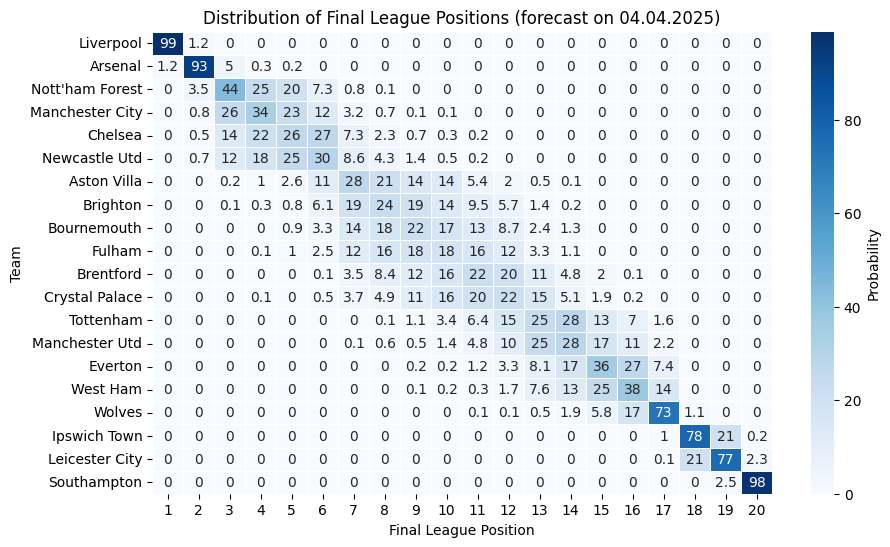

In [30]:
# Determine the most common position for each team (highest count)
#dominant_positions = result_matrix.idxmax(axis=1)
# Sort teams based on their most common position
#sorted_teams = dominant_positions.sort_values().index

# Reorder the matrix based on average final league position
sorted_teams = simulation_results_df.groupby(['Squad'])['Rk'].mean().sort_values().index
sorted_matrix = result_matrix.loc[sorted_teams]

# Plot the reordered heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(sorted_matrix, annot=True, cmap="Blues", linewidths=0.5, cbar_kws={'label': 'Probability'})

timestamp = datetime.now().strftime("%d.%m.%Y")
plt.title(f"Distribution of Final League Positions (forecast on {timestamp})")
plt.xlabel("Final League Position")
plt.ylabel("Team")

plt.savefig('league_distribution.png')

plt.show()

In [31]:
weekly_scores = (manager_results_df.groupby(['gameweek', 'team']).sum() / nr_simulations).reset_index()
#weekly_scores['quantile_10'] = manager_results_df.groupby(['gameweek', 'team']).quantile(0.10).reset_index()['expected_points']
#weekly_scores['quantile_30'] = manager_results_df.groupby(['gameweek', 'team']).quantile(0.30).reset_index()['expected_points']
#weekly_scores['quantile_70'] = manager_results_df.groupby(['gameweek', 'team']).quantile(0.70).reset_index()['expected_points']
#weekly_scores['quantile_90'] = manager_results_df.groupby(['gameweek', 'team']).quantile(0.90).reset_index()['expected_points']
#weekly_scores

In [32]:
# fill weeks with no game with 0 manager points
# Get all unique gameweeks and teams
all_gameweeks = range(int(weekly_scores['gameweek'].min()), int(weekly_scores['gameweek'].max()) + 1)
all_teams = weekly_scores['team'].unique()

# Create a MultiIndex for all possible gameweek-team combinations
idx = pd.MultiIndex.from_product([all_gameweeks, all_teams], names=['gameweek', 'team'])

# Reindex the DataFrame to include missing gameweeks for each team
weekly_scores = weekly_scores.set_index(['gameweek', 'team']).reindex(idx, fill_value=0).reset_index()

weekly_scores

,gameweek,team,expected_points,simulation_nr
0,31,Arsenal,6.891,499.5
1,31,Aston Villa,4.691,499.5
2,31,Bournemouth,6.053,499.5
3,31,Brentford,8.814,499.5
4,31,Brighton,3.664,499.5
...,...,...,...,...
155,38,Nott'ham Forest,4.336,499.5
156,38,Southampton,2.004,499.5
157,38,Tottenham,9.867,499.5
158,38,West Ham,5.393,499.5


In [33]:
fig = px.line(weekly_scores, x='gameweek', y='expected_points', color='team', markers=True,
              title="Expected Points per Game Week",
              labels={"expected_points": "Expected Points", "gameweek": "Game Week"})

fig.show()

In [34]:
# Get unique teams
teams = np.sort(weekly_scores['team'].unique())
default_team = teams[0]  # Default highlighted team

# Create figure
fig = go.Figure()

for team in teams:
    fig.add_trace(go.Scatter(
        x=weekly_scores[weekly_scores['team'] == team]['gameweek'],
        y=weekly_scores[weekly_scores['team'] == team]['expected_points'],
        mode='lines+markers',
        name=team,
        line=dict(color='blue' if team == default_team else 'gray'),
        opacity=1 if team == default_team else 0.3,
        visible=True
    ))

# Create dropdown menu
dropdown_buttons = []
for selected_team in teams:
    button = {
        "label": selected_team,
        "method": "update",
        "args": [
            {
                "opacity": [1 if team == selected_team else 0.3 for team in teams],
                "line": [dict(color="blue" if team == selected_team else "gray") for team in teams],
            },
            {"title": f"Expected Points per Game Week - {selected_team}"}
        ]
    }
    dropdown_buttons.append(button)

# Add dropdown menu
fig.update_layout(
    title=f"Expected Points per Game Week - {default_team}",
    xaxis_title="Game Week",
    yaxis_title="Expected Points",
    updatemenus=[{
        "buttons": dropdown_buttons,
        "direction": "down",
        "showactive": True,
    }]
)

fig.show()

In [35]:
weekly_scores[["rolling_expected_points"]] = weekly_scores.groupby("team").rolling(3, on='gameweek').sum().reset_index(level=0, drop=True)[["expected_points"]]
#weekly_scores[["rolling_quantile_10", "rolling_quantile_30", "rolling_expected_points", "rolling_quantile_70", "rolling_quantile_90"]] = weekly_scores.groupby("team").rolling(3, on='gameweek').sum().reset_index(level=0, drop=True)[["quantile_10", "quantile_30", "expected_points", "quantile_70", "quantile_90"]]
weekly_scores

,gameweek,team,expected_points,simulation_nr,rolling_expected_points
0,31,Arsenal,6.891,499.5,NaN
1,31,Aston Villa,4.691,499.5,NaN
2,31,Bournemouth,6.053,499.5,NaN
3,31,Brentford,8.814,499.5,NaN
4,31,Brighton,3.664,499.5,NaN
...,...,...,...,...,...
155,38,Nott'ham Forest,4.336,499.5,18.910
156,38,Southampton,2.004,499.5,7.919
157,38,Tottenham,9.867,499.5,24.322
158,38,West Ham,5.393,499.5,16.399


In [36]:
# Get unique teams
teams = np.sort(weekly_scores['team'].unique())
default_team = teams[0]  # Default highlighted team

# Create figure
fig = go.Figure()

for team in teams:
    fig.add_trace(go.Scatter(
        x=weekly_scores[weekly_scores['team'] == team]['gameweek'],
        y=weekly_scores[weekly_scores['team'] == team]['rolling_expected_points'],
        mode='lines+markers',
        name=team,
        line=dict(color='blue' if team == default_team else 'gray'),
        opacity=1 if team == default_team else 0.3,
        visible=True
    ))

# Create dropdown menu
dropdown_buttons = []
for selected_team in teams:
    button = {
        "label": selected_team,
        "method": "update",
        "args": [
            {
                "opacity": [1 if team == selected_team else 0.3 for team in teams],
                "line": [dict(color="blue" if team == selected_team else "gray") for team in teams],
            },
            {"title": f"3-week Rolling Sum of Expected Points - {selected_team}"}
        ]
    }
    dropdown_buttons.append(button)

# Add dropdown menu
fig.update_layout(
    title=f"3-week Rolling Sum of Expected Points - {default_team}",
    xaxis_title="Gameweek",
    yaxis_title="Expected Points",
    updatemenus=[{
        "buttons": dropdown_buttons,
        "direction": "down",
        "showactive": True,
    }]
)

fig.show()

# Development

In [ ]:
manager_xp = []
for _, row in fixtures.iterrows():
    if np.isnan(row.event):
        continue
    else:
        # calculate expected goals for both teams
        home_team_xg = poisson_model.predict(pd.DataFrame(data={'team': row.home_team, 'opponent': row.away_team, 'home':1},index=[1])).values[0]
        away_team_xg = poisson_model.predict(pd.DataFrame(data={'team': row.away_team, 'opponent': row.home_team, 'home':0},index=[1])).values[0]
        
        # CALCULATE EXPECTED MANAGER POINTS FOR HOME TEAM
        new_row1 = [row.event, row.home_team, 0]
        table_bonus_coefficient = table_bonus_check(row.home_team, row.away_team, league_table) # 1 or 0
        # points for win
        new_row1[2] += (6 + 10*table_bonus_coefficient)*row.home_win_probability
        # points for draw
        new_row1[2] += (3 + 5*table_bonus_coefficient)*row.draw_probability
        # expected goals scored
        new_row1[2] += home_team_xg
        # points for clean sheet
        new_row1[2] += 2*poisson.pmf(0, away_team_xg)

        # CALCULATE EXPECTED MANAGER POINTS FOR AWAY TEAM
        new_row2 = [row.event, row.away_team, 0]
        table_bonus_coefficient = table_bonus_check(row.away_team, row.home_team, league_table) # 1 or 0
        # points for win
        new_row2[2] += (6 + 10*table_bonus_coefficient)*row.away_win_probability
        # points for draw
        new_row2[2] += (3 + 5*table_bonus_coefficient)*row.draw_probability
        # expected goals scored
        new_row2[2] += away_team_xg
        # points for clean sheet
        new_row2[2] += 2*poisson.pmf(0, home_team_xg)

        # add rows to manager_xp
        manager_xp.extend([new_row1, new_row2])
        
manager_df = pd.DataFrame(manager_xp, columns=['gameweek', 'team', 'expected_points'])
manager_df

In [ ]:
weekly_scores = manager_df.groupby(['gameweek', 'team']).sum().reset_index()
weekly_scores

## Simulate season

In [ ]:
def simulate_match(foot_model, homeTeam, awayTeam):
    '''
    Simulate the outcome of a single match.
    '''
    
    # simulate scoreline
    home_goals_avg_, away_goals_avg_ = predict_average_goals(foot_model, homeTeam, awayTeam)
    home_goals = poisson.rvs(home_goals_avg_)
    away_goals = poisson.rvs(away_goals_avg_)

    if home_goals > away_goals:
        outcome = 'home_win'
    elif home_goals == away_goals:   
        outcome = 'draw'
    else:
        outcome = 'away_win'

    return outcome, home_goals, away_goals
    #return choices(['home_win', 'draw', 'away_win'], probabilities)[0]

In [ ]:
def simulate_season(league_table, fixtures, foot_model):
    '''Simulate a whole season.'''
    for _, fixture in fixtures.iterrows():
        home_team_ = fixture.Home
        away_team_ = fixture.Away
        # simulate match outcome
        outcome, home_goals, away_goals = simulate_match(foot_model, home_team_, away_team_)
        # update matches played
        league_table.loc[league_table['Squad']==home_team_, 'MP'] += 1
        league_table.loc[league_table['Squad']==away_team_, 'MP'] += 1
        # update league table 
        league_table.loc[league_table['Squad']==home_team_, 'GF'] += home_goals
        league_table.loc[league_table['Squad']==home_team_, 'GA'] += away_goals
        league_table.loc[league_table['Squad']==home_team_, 'GD'] += home_goals - away_goals
        league_table.loc[league_table['Squad']==away_team_, 'GF'] += away_goals
        league_table.loc[league_table['Squad']==away_team_, 'GA'] += home_goals
        league_table.loc[league_table['Squad']==away_team_, 'GD'] += away_goals - home_goals
        if outcome=='home_win':
            league_table.loc[league_table['Squad']==home_team_, 'Pts'] += 3
            league_table.loc[league_table['Squad']==home_team_, 'W'] += 1
            league_table.loc[league_table['Squad']==away_team_, 'L'] += 1
        elif outcome=='draw':
            league_table.loc[league_table['Squad']==home_team_, 'Pts'] += 1
            league_table.loc[league_table['Squad']==away_team_, 'Pts'] += 1
            league_table.loc[league_table['Squad']==home_team_, 'D'] += 1
            league_table.loc[league_table['Squad']==away_team_, 'D'] += 1
        elif outcome=='away_win':
            league_table.loc[league_table['Squad']==away_team_, 'Pts'] += 3
            league_table.loc[league_table['Squad']==away_team_, 'W'] += 1
            league_table.loc[league_table['Squad']==home_team_, 'L'] += 1
        else: 
            print('No valid result for:')
            print(fixture)
    
    assert np.all(league_table['MP']==38), 'All teams have not played 38 games!'

    league_table = league_table.sort_values(by=['Pts', 'GD', 'GF'], ascending=False)
    league_table['Rk'] = np.arange(1,21)

    return league_table

In [ ]:
league_table = pd.read_html('https://fbref.com/en/comps/9/Premier-League-Stats')[0]
league_table

In [ ]:
simulated_table = simulate_season(league_table[['Squad', 'MP', 'W', 'D', 'L', 'GF', 'GA', 'GD', 'Pts']].copy(), fixtures, poisson_model)
display(simulated_table)

In [ ]:
nr_simulations = 1000
simulation_results = []
for i in tqdm(range(nr_simulations), desc='Simulating...'):
    simulated_table = simulate_season(league_table[['Squad', 'MP', 'W', 'D', 'L', 'GF', 'GA', 'GD', 'Pts']].copy(), fixtures, poisson_model)
    simulated_table['simulation_nr'] = i
    simulation_results.append(simulated_table)
print('Done!')

simulation_results_df = pd.concat(simulation_results).reset_index(drop=True)

In [ ]:
result_matrix = (
    simulation_results_df.groupby(['Squad', 'Rk'])
    .size()
    .unstack(fill_value=0)
    .reindex(columns=range(1, 21), fill_value=0)  # Ensure columns go from 1 to 20
)

# normalize to percentage
result_matrix = 100 * (result_matrix / nr_simulations)

In [ ]:
# Determine the most common position for each team (highest count)
#dominant_positions = result_matrix.idxmax(axis=1)
# Sort teams based on their most common position
#sorted_teams = dominant_positions.sort_values().index

# Reorder the matrix based on average final league position
sorted_teams = simulation_results_df.groupby(['Squad'])['Rk'].mean().sort_values().index
sorted_matrix = result_matrix.loc[sorted_teams]

# Plot the reordered heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(sorted_matrix, annot=True, cmap="Blues", linewidths=0.5, cbar_kws={'label': 'Probability'})

timestamp = datetime.now().strftime("%d.%m.%Y")
plt.title(f"Distribution of Final League Positions (forecast on {timestamp})")
plt.xlabel("Final League Position")
plt.ylabel("Team")

plt.show()